In [1]:
import subprocess
subprocess.Popen(['ipcluster', 'start', '-n', '8'])

In [2]:
from ipyparallel import Client, require
worker = Client()

In [3]:
lview = worker[:]

# now if you want to import packages, you can import them across all the 'engines'
with lview.sync_imports():    
    import numpy as np
    from scipy import stats
    import pymc3 as pm
    import theano
    import theano.tensor as tt
    import pandas as pd
    import os

# there's not much point in creating plots on the engines - we want to actually see them presumably
%matplotlib inline
import matplotlib.pyplot as plt
from pymc3 import floatX as floatX_pymc3
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
import arviz as az
from astropy.table import Table
from warnings import filterwarnings

# If everything has worked so far, you should see a list of
worker IDs, and a corresponding list of process IDs.
# You can verify it with a `ps`
ar = lview.apply_async(os.getpid)
print("Engine ID:PID mapping: ", ar.get_dict())

importing numpy on engine(s)
importing stats from scipy on engine(s)
importing pymc3 on engine(s)
importing theano on engine(s)
importing theano.tensor on engine(s)
importing pandas on engine(s)
importing os on engine(s)
Engine ID:PID mapping:  {0: 16637, 1: 16638, 2: 16639, 3: 16640, 4: 16643, 5: 16644, 6: 16645, 7: 16650}


In [4]:
filterwarnings('ignore')

layer_names = ['w_in_1_grp', 'w_2_out_grp', 'b_in_1_grp', 'b_2_out_grp']

np.random.seed(1234)

floatX = theano.config.floatX

In [5]:
def norm(data,eData):
    
    mu  = np.mean(data,axis=0)
    std = np.std(data, axis=0)
    
    scaleData  = (data-mu)/std
    scaleEData = eData/std

    return(scaleData,scaleEData)

def get_data(input_data):
    
    # Assuming your data is in a fits table you want to make it into a pandas dataframe (maybe to use if for Keras)
    # Assumes here you've done most of the data handling in a different code
    df = input_data.to_pandas()
    
    # Here is when you choose the sample size for your data etc
    
    train_dataset = df.sample(frac=1.0,random_state=0)
    train_stats = train_dataset.describe()
 
    loggTrain = np.array(train_dataset['logg']).astype(floatX)
    alphamTrain = np.array(train_dataset['alpha_m']).astype(floatX)
    teffTrain = np.array(train_dataset['Teff']).astype(floatX)
    mhTrain = np.array(train_dataset['mh']).astype(floatX)
    cfeTrain = np.array(train_dataset['cfe']).astype(floatX)
    nfeTrain = np.array(train_dataset['nfe']).astype(floatX)
    gmagTrain = np.array(train_dataset['G']).astype(floatX)
    bpmagTrain = np.array(train_dataset['BP']).astype(floatX)
    rpmagTrain = np.array(train_dataset['RP']).astype(floatX)
    jmagTrain = np.array(train_dataset['J']).astype(floatX)
    hmagTrain = np.array(train_dataset['H']).astype(floatX)
    kmagTrain = np.array(train_dataset['K']).astype(floatX)

    logAgeTrain = np.array(train_dataset['logAge']).astype(floatX)

    loggTrain_err = np.array(train_dataset['logg_err']).astype(floatX)
    alphamTrain_err = np.array(train_dataset['alpham_err']).astype(floatX)
    teffTrain_err = np.array(train_dataset['Teff_err']).astype(floatX)
    mhTrain_err = np.array(train_dataset['mh_err']).astype(floatX)
    cfeTrain_err = np.array(train_dataset['cfe_err']).astype(floatX)
    nfeTrain_err = np.array(train_dataset['nfe_err']).astype(floatX)
    gmagTrain_err = np.array(train_dataset['G_err']).astype(floatX)
    bpmagTrain_err = np.array(train_dataset['BP_err']).astype(floatX)
    rpmagTrain_err = np.array(train_dataset['RP_err']).astype(floatX)
    jmagTrain_err= np.array(train_dataset['J_err']).astype(floatX)
    hmagTrain_err = np.array(train_dataset['H_err']).astype(floatX)
    kmagTrain_err = np.array(train_dataset['K_err']).astype(floatX)

    logAgeTrain_err =  np.array(train_dataset['logAge_err']).astype(floatX)

    inputsTrain = np.column_stack((loggTrain, alphamTrain, teffTrain, mhTrain, cfeTrain, nfeTrain, \
                               gmagTrain, bpmagTrain, rpmagTrain, jmagTrain, hmagTrain, kmagTrain))
    errInputsTrain = np.column_stack((loggTrain_err, alphamTrain_err, teffTrain_err, mhTrain_err, cfeTrain_err, nfeTrain_err, \
                                  gmagTrain_err, bpmagTrain_err, rpmagTrain_err, jmagTrain_err, \
                                  hmagTrain_err, kmagTrain_err))

    targetsTrain    = np.array(logAgeTrain)
    errTargetsTrain = np.array(logAgeTrain_err)
    
    # Make the arrays a floatX array
    inputsTrain = inputsTrain.astype(floatX)
    errInputsTrain = errInputsTrain.astype(floatX)

    targetsTrain = targetsTrain.astype(floatX)
    errTargetsTrain = errTargetsTrain.astype(floatX)

    # First rule of a machine learning project: standardize the data
    # Note: might need the mu and standard deviation but for now I think we are fine
    
    inputsTrain, errInputsTrain = norm(inputsTrain, errInputsTrain)

    return inputsTrain, errInputsTrain, targetsTrain, errTargetsTrain

datA = Table.read('./HBNN_train_data/datasetA.fits')
datB = Table.read('./HBNN_train_data/datasetA.fits')
datC = Table.read('./HBNN_train_data/datasetA.fits')
datD = Table.read('./HBNN_train_data/datasetA.fits')

len(datA)

2329

In [6]:
inputsTrain_A, errInputsTrain_A, targetsTrain_A, errTargetsTrain_A = get_data(datA)

inputsTrain_B, errInputsTrain_B, targetsTrain_B, errTargetsTrain_B = get_data(datB)

inputsTrain_C, errInputsTrain_C, targetsTrain_C, errTargetsTrain_C, = get_data(datC)

inputsTrain_D, errInputsTrain_D, targetsTrain_D, errTargetsTrain_D = get_data(datD)

ntrain = len(inputsTrain_A)
print("Number of training samples: ", ntrain)

XsTrain = np.stack([inputsTrain_A, inputsTrain_B, inputsTrain_C])
YsTrain = np.stack([targetsTrain_A, targetsTrain_B, targetsTrain_C])

errXsTrain = np.stack([errInputsTrain_A, errInputsTrain_B, errInputsTrain_C])
errYsTrain = np.stack([errTargetsTrain_A, errTargetsTrain_B, errTargetsTrain_C])

XsTrain = theano.shared(XsTrain)
YsTrain = theano.shared(YsTrain)
errXsTrain = theano.shared(errXsTrain)
errYsTrain = theano.shared(errYsTrain)

XsTrain.shape.eval()

Number of training samples:  2329


array([   3, 2329,   12])

In [7]:
n_hidden = 5
n_grps = XsTrain.shape[0].eval()
n_data = XsTrain.shape[2].eval()
ntargets = 1

def hierarchical_NN(annInput, errAnnInput, annTarget, errAnnTarget):
    
    # Initialize random weights between each layer
    init_1 = floatX_pymc3(np.random.randn(n_data, n_hidden))
    init_2 = floatX_pymc3(np.random.randn(n_hidden, n_hidden))
    init_out = floatX_pymc3(np.random.randn(n_hidden))
        
    # Initialize random biases between each layer
    bias_init_1  = np.random.randn(n_hidden)
    bias_out = np.random.randn(ntargets)
    
    with pm.Model() as neural_network:
        
        # Group mean distribution for input to hidden layer    
        Xs_true = pm.Normal('xtrue', mu = 0, sd = 20, shape = annInput.shape.eval(), testval=annInput.eval())
        weights_in_1_grp = pm.Normal('w_in_1_grp', 0, sd=1., 
                                 shape=(n_data, n_hidden), 
                                 testval=init_1)
    
        # Group standard-deviation
        weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=1.)
        biases_in_1_grp = pm.Normal('b_in_1_grp', 0, sd=1., shape=(n_hidden), testval = bias_init_1)
        biases_in_1_grp_sd = pm.HalfNormal('b_in_1_grp_sd', sd=1.)
        
        # Group mean distribution from hidden layer to output
        weights_2_out_grp = pm.Normal('w_2_out_grp', 0, sd=1., 
                                  shape=(n_hidden,), 
                                  testval=init_out)
    
        weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=1.)
        biases_2_out_grp = pm.Normal('b_2_out_grp', 0, sd=1., shape=(ntargets,), testval=bias_out)
        biases_2_out_grp_sd = pm.HalfNormal('b_2_out_grp_sd', sd=1.)
    
        # Separate weights for each different model, just add a 3rd dimension
        # of weights
        weights_in_1_raw = pm.Normal('w_in_1', 
                                     shape=(n_grps, n_data, n_hidden))
        
        # Non-centered specification of hierarchical model
        # see https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/
        weights_in_1 = weights_in_1_raw * weights_in_1_grp_sd + weights_in_1_grp
    
        biases_in_1_raw = pm.Normal('b_in_1', shape = (n_grps, 1, n_hidden,))
        biases_in_1 = biases_in_1_raw * biases_in_1_grp_sd + biases_in_1_grp

        weights_2_out_raw = pm.Normal('w_2_out', 
                                      shape=(n_grps, n_hidden))
        weights_2_out = weights_2_out_raw * weights_2_out_grp_sd + weights_2_out_grp
    
        biases_2_out_raw = pm.Normal('b_2_out', shape=(n_grps, ntargets))
        biases_2_out = biases_2_out_raw * biases_2_out_grp_sd + biases_2_out_grp
        
        # Build neural-network using tanh activation function
        # tt.batched_dot just calls .dot along an axis
        
        act_1 = tt.nnet.relu(tt.batched_dot(Xs_true, weights_in_1) + biases_in_1)
        
        # Debug 1: get rid of he biases_in_2; see if it works
        # Debug 2: will use ReLU
        # Debug 3: look into the uncertainties
        # Debug 4: look at changing the prior on the biases
    
        act_out = tt.batched_dot(act_1, weights_2_out) + biases_2_out
        
        pred = pm.Deterministic('pred', act_out)
        likelihood_x = pm.Normal('x', mu = Xs_true, sd = errAnnInput, observed = annInput)
     
        out = pm.Normal('out', mu=pred, observed=annTarget, sd = errAnnTarget)
    
    return neural_network

In [8]:
neural_network = hierarchical_NN(XsTrain, errXsTrain, YsTrain, errYsTrain)

In [9]:
with neural_network:
        #fit model
        trace_hier = pm.sample(init='advi+adapt_diag', tune=100, chains=1, 
                     nuts_kwargs={'target_accept': 0.9}, 
                     progressbar=True)
        # sample posterior predictive
        ppc_train = pm.sample_ppc(trace_hier, samples=100, progressbar=True) 
        pred_train = ppc_train['out'].mean(axis=0) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 3.2779e+05: 100%|██████████| 200000/200000 [1:39:44<00:00, 33.42it/s]    
Finished [100%]: Average Loss = 3.2779e+05
Sequential sampling (1 chains in 1 job)
NUTS: [b_2_out, w_2_out, b_in_1, w_in_1, b_2_out_grp_sd, b_2_out_grp, w_2_out_grp_sd, w_2_out_grp, b_in_1_grp_sd, b_in_1_grp, w_in_1_grp_sd, w_in_1_grp, xtrue]
100%|██████████| 600/600 [35:16<00:00,  2.89s/it]  
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.306591040153818, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
100%|██████████| 100/100 [00:05<00:00, 24.57it/s]


In [10]:
YsTrain.shape.eval()
ysTrain_0 = YsTrain.eval()[0]
ysTrain_1 = YsTrain.eval()[1]
ysTrain_2 = YsTrain.eval()[2]
ysTrain_0.shape
targetmin = -0.25
targetmax = 1.25

(-0.3, 1.3)

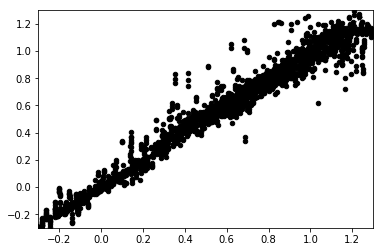

In [11]:
plt.scatter(ysTrain_0, pred_train[0], color='k', s=20)
plt.plot([targetmin,targetmax],[targetmin,targetmax],':k',linewidth=1)
plt.xlim(-0.3, 1.3)
plt.ylim(-0.3, 1.3)

In [12]:
from collections import defaultdict
samples_tmp = defaultdict(list)
samples = {}

for layer_name in layer_names:
    for mu, sd in zip(trace_hier.get_values(layer_name, chains=0),
                      trace_hier.get_values(layer_name+'_sd', chains=0)):
        for _ in range(20): # not sure why the `size` kwarg doesn't work
            samples_tmp[layer_name].append(stats.norm(mu, sd).rvs())
    samples[layer_name] = np.asarray(samples_tmp[layer_name])

In [69]:
def flat_bnn(annInput, errAnnInput, annTarget, errAnnTarget):
    
    annInput = theano.shared(annInput)
    errAnnInput = theano.shared(errAnnInput)
    annTarget = theano.shared(annTarget)
    errAnnTarget = theano.shared(errAnnTarget)
    
    n_samples = samples['w_in_1_grp'].shape[0]
    n_hidden = 5   
    prior_1_mu=samples['w_in_1_grp'].mean(axis=0)
    bias_1_mu=samples['b_in_1_grp'].mean(axis=0)
    prior_1_cov=np.cov(samples['w_in_1_grp'].reshape((n_samples, -1)).T)
    bias_1_cov = np.cov(samples['b_in_1_grp'].reshape((n_samples, -1)).T)
    prior_out_mu=samples['w_2_out_grp'].mean(axis=0)
    bias_out_mu=samples['b_2_out_grp'].mean(axis=0)
    prior_out_cov=np.cov(samples['w_2_out_grp'].reshape((n_samples, -1)).T)
    bias_out_cov=np.cov(samples['b_2_out_grp'].reshape((n_samples, -1)).T)

    with pm.Model() as flat_neural_network:

        Xs_true = pm.Normal('xtrue', mu = 0, sd = 20, shape = annInput.shape.eval(), testval=annInput.eval())
        
        # In order to model the correlation structure between the 2D weights,
        # we flatten them first. Now here we have to reshape to give them their
        # original 2D shape.
        
        weights_in_1 = (pm.MvNormal('w_in_1', prior_1_mu.flatten(), 
                                   cov=prior_1_cov, 
                                   shape=prior_1_cov.shape[0]).reshape((n_data, n_hidden)))
        print(weights_in_1.tag.test_value.shape)
        
        bias_in_1 = (pm.MvNormal('bias_in_1', bias_1_mu.flatten(),
                              cov      = bias_1_cov,
                              shape   = bias_1_cov.shape[0]).reshape((n_hidden,)))
        
        # Weights from hidden layer to output
        weights_2_out = (pm.MvNormal('w_2_out', prior_out_mu.flatten(), 
                                    cov=prior_out_cov, 
                                    shape=prior_out_cov.shape[0]).reshape((n_hidden,)))
        
        bias_2_out = (pm.Normal('bias_2_out', mu = bias_out_mu.flatten(), sd = bias_out_cov, shape = (ntargets)).reshape((ntargets,)))
        
        # Build neural-network using tanh activation function
        act_1 =  tt.nnet.relu(tt.dot(Xs_true, weights_in_1) + bias_in_1) 
    
        act_out = tt.dot(act_1, weights_2_out) + bias_2_out
        pred = pm.Deterministic('pred', act_out)
        likelihood_x = pm.Normal('x', mu = Xs_true, sd = errAnnInput, observed = annInput)
     
        out = pm.Normal('out', pred, observed=annTarget, sd = errAnnTarget)
    
    return flat_neural_network

In [14]:
XsTrainBNN =  inputsTrain_D
YsTrainBNN =  targetsTrain_D
errXsTrainBNN = errInputsTrain_D
errYsTrainBNN =  errTargetsTrain_D

In [70]:
bnn_neural_network = flat_bnn(XsTrainBNN, errXsTrainBNN, YsTrainBNN, errYsTrainBNN)

(12, 5)


In [71]:
with bnn_neural_network:
        #fit model
        trace_bnn = pm.sample(init='advi+adapt_diag', tune=100, chains=1, 
                     nuts_kwargs={'target_accept': 0.9}, 
                     progressbar=True)
        # sample posterior predictive
        bnn_ppc_train = pm.sample_ppc(trace_bnn, samples=100, progressbar=True) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 1.0951e+05: 100%|██████████| 200000/200000 [36:54<00:00, 90.32it/s]  
Finished [100%]: Average Loss = 1.0951e+05
Sequential sampling (1 chains in 1 job)
NUTS: [bias_2_out, w_2_out, bias_in_1, w_in_1, xtrue]
100%|██████████| 600/600 [30:35<00:00,  2.82s/it]
Only one chain was sampled, this makes it impossible to run some convergence checks
100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


(-0.3, 1.3)

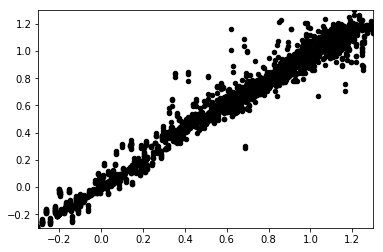

In [72]:
bnn_pred_train = bnn_ppc_train['out'].mean(axis=0)

plt.scatter(YsTrainBNN, bnn_pred_train, color='k', s=20)

plt.xlim(-0.3, 1.3)
plt.ylim(-0.3, 1.3)

In [73]:
def get_test_data(test_data):
    
    # Assuming your data is in a fits table you want to make it into a pandas dataframe (maybe to use if for Keras)
    # Assumes here you've done most of the data handling in a different code
    test_dataset = pd.read_csv(test_data)
    test_stats = test_dataset.describe()
 
    loggTest = np.array(test_dataset['LOGG']).astype(floatX)
    alphamTest = np.array(test_dataset['ALPHA_M']).astype(floatX)
    teffTest = np.array(test_dataset['TEFF']).astype(floatX)
    mhTest = np.array(test_dataset['M_H']).astype(floatX)
    cfeTest = np.array(test_dataset['C_FE']).astype(floatX)
    nfeTest = np.array(test_dataset['N_FE']).astype(floatX)
    gmagTest = np.array(test_dataset['phot_g_mean_mag']).astype(floatX)
    bpmagTest = np.array(test_dataset['phot_bp_mean_mag']).astype(floatX)
    rpmagTest = np.array(test_dataset['phot_rp_mean_mag']).astype(floatX)
    jmagTest = np.array(test_dataset['J']).astype(floatX)
    hmagTest = np.array(test_dataset['H']).astype(floatX)
    kmagTest = np.array(test_dataset['K']).astype(floatX)

    age = test_dataset['age']
    age_68u = np.asarray(test_dataset['age_68u']).astype('f8')
    age_68l = np.asarray(test_dataset['age_68l']).astype('f8')
    logAge = np.log10(age)
    logAge_err = (np.log10(age_68u) - np.log10(age_68l))/2.0
    
    logAgeTest = np.array(logAge).astype(floatX)
    logAgeTest_err = np.array(logAge_err).astype(floatX)

    loggTest_err = np.array(test_dataset['LOGG_ERR']).astype(floatX)
    alphamTest_err = np.array(test_dataset['ALPHA_M_ERR']).astype(floatX)
    teffTest_err = np.array(test_dataset['TEFF_ERR']).astype(floatX)
    mhTest_err = np.array(test_dataset['M_H_ERR']).astype(floatX)
    cfeTest_err = np.array(test_dataset['C_FE_ERR']).astype(floatX)
    nfeTest_err = np.array(test_dataset['N_FE_ERR']).astype(floatX)
    
    g_mag = np.asarray(test_dataset['phot_g_mean_mag']).astype('f8')
    g_flux = np.asarray(test_dataset['phot_g_mean_flux']).astype('f8')
    g_flux_error = np.asarray(test_dataset['phot_g_mean_flux_error']).astype('f8')
    gmag_err = 0.01 + 0.5 * 2.5 * (np.log10((g_flux + g_flux_error )/g_flux) - np.log10((g_flux - g_flux_error )/g_flux))
    gmagTest_err = np.array(gmag_err).astype(floatX)
    
    bp_mag = np.asarray(test_dataset['phot_bp_mean_mag']).astype('f8')
    bp_flux = np.asarray(test_dataset['phot_bp_mean_flux'].astype('f8'))
    bp_flux_error = np.asarray(test_dataset['phot_bp_mean_flux_error']).astype('f8')
    bpmag_err = 0.01 + 0.5 * 2.5 * (np.log10((bp_flux + bp_flux_error )/bp_flux) - np.log10((bp_flux - bp_flux_error )/bp_flux))
    bpmagTest_err = np.array(bpmag_err).astype(floatX)
    
    rp_mag = np.asarray(test_dataset['phot_rp_mean_mag']).astype('f8')
    rp_flux = np.asarray(test_dataset['phot_rp_mean_flux']).astype('f8')
    rp_flux_error = np.asarray(test_dataset['phot_rp_mean_flux_error']).astype('f8')
    rpmag_err = 0.01 +  0.5 * 2.5 * (np.log10((rp_flux + rp_flux_error )/rp_flux) - np.log10((rp_flux - rp_flux_error )/rp_flux))
    
    rpmagTest_err = np.array(rpmag_err).astype(floatX)
    
    jmagTest_err = np.array(test_dataset['J_ERR']).astype(floatX)
    hmagTest_err = np.array(test_dataset['H_ERR']).astype(floatX)
    kmagTest_err = np.array(test_dataset['K_ERR']).astype(floatX)

    inputsTest = np.column_stack((loggTest, alphamTest, teffTest, mhTest, cfeTest, nfeTest, \
                               gmagTest, bpmagTest, rpmagTest, jmagTest, hmagTest, kmagTest))
    errInputsTest = np.column_stack((loggTest_err, alphamTest_err, teffTest_err, mhTest_err, cfeTest_err, nfeTest_err, \
                                  gmagTest_err, bpmagTest_err, rpmagTest_err, jmagTest_err, \
                                  hmagTest_err, kmagTest_err))

    targetsTest    = np.array(logAgeTest)
    errTargetsTest = np.array(logAgeTest_err)
    
    inputsTest, errInputsTest = norm(inputsTest, errInputsTest)

    return inputsTest, errInputsTest, targetsTest, errTargetsTest

In [74]:
test = './training_data/test.csv'

inputsTest, errInputsTest, targetsTest, errTargetsTest = get_test_data(test)

In [55]:
XTest = inputsTest
errXTest = errInputsTest
YTest = targetsTest
errYTest = errTargetsTest

Xtest.shape[0]

292

In [43]:
n_data

w1 = bnn_neural_network.w_in_1
b1 = bnn_neural_network.bias_in_1
w2 = bnn_neural_network.w_2_out
b2 = bnn_neural_network.bias_2_out

w_2_out

In [82]:
with bnn_neural_network:
    
        xtest = pm.Normal('XTest_new', mu = XTest, sd = errXTest, shape = XTest.shape)
        
        w1 = bnn_neural_network.w_in_1.reshape((n_data, n_hidden))
        b1 = bnn_neural_network.bias_in_1.reshape((n_hidden,))
        w2 = bnn_neural_network.w_2_out.reshape((n_hidden,))
        b2 = bnn_neural_network.bias_2_out.reshape((ntargets,))
        
        act_1 =  tt.nnet.relu(tt.dot(xtest, w1) + b1)
        act_out = tt.dot(act_1, w2) + b2
        
        test_out = pm.Normal('test_out_new', act_out, observed = YTest, sd = errYTest)
        ppc_test = pm.sample_ppc(trace_bnn, vars = [xtest, test_out], samples = 1000)

100%|██████████| 100000/100000 [03:56<00:00, 422.84it/s]


In [51]:
print(bnn_neural_network.w_in_1.tag.test_value.shape)
print(bnn_neural_network.Xtest_h.tag.test_value.shape)

(60,)
(292, 12)


In [83]:
pred_test = ppc_test['test_out_new'].mean(axis=0)

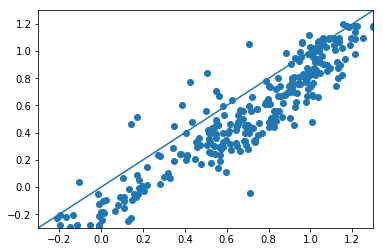

In [84]:
plt.scatter(targetsTest, pred_test)
plt.xlim(-0.3, 1.3)
plt.ylim(-0.3, 1.3)
plt.plot([-0.3, 1.3], [-0.3, 1.3])

In [85]:
len(targetsTest)

292

(array([ 5.,  9., 24., 15., 20., 42., 48., 49., 61., 19.]),
 array([-0.33885014, -0.175139  , -0.01142786,  0.15228327,  0.31599441,
         0.47970555,  0.64341669,  0.80712783,  0.97083897,  1.13455011,
         1.29826125]),
 <a list of 10 Patch objects>)

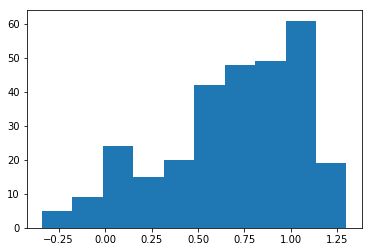

In [86]:
plt.hist(targetsTest)

(array([188., 213., 237., 203., 216., 268., 288., 236., 275., 205.]),
 array([-0.3444774 , -0.18036797, -0.01625854,  0.1478509 ,  0.31196033,
         0.47606976,  0.6401792 ,  0.80428863,  0.96839807,  1.1325075 ,
         1.29661693]),
 <a list of 10 Patch objects>)

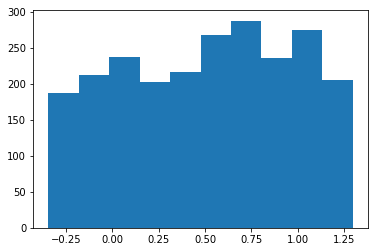

In [89]:
plt.hist(YsTrainBNN)